<a href="https://colab.research.google.com/github/Zain-mahfoud94/Python-Uni/blob/main/Lecture_Autonomous_Learning_Transfer_Learning_Excercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Excercise: Transfer Learning

by Stephan Vogt

### Lecture: Autonomous Learning, WS 2021/22

The code below shows a toy example of transfer learning. Here, we use the famous MNIST data set [1]. The data set comprises 60.000 training and 10.000 test samples. Each input is given with 784 dimensions (or as an 28 x 28 grayscale image). Each sample is one of ten classes, which represent the digits 0, 1, ... 9. In our case, we furthermore split the dataset into a source and a target dataset.

The code below makes extensive use of the pytorch library. If you need more input, I recommend: https://www.youtube.com/playlist?list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4

Your tasks in this exercise are given with the following questions. To all questions: please note your arguments.

1. Execute the code below and trace the individual steps. Which type of transfer learning is applied? Inductive, transductive or unsupervised transfer learning?
1. Can the applied method be referred to as "multi-task learning"?
2. Are source and target domain the same?
2. How about the source and target tasks? Are they different?
3. Analyse the train function: Which strategy is applied to prevent overfitting?
3. Write down the Test-Accuracy for the model with and without transfer learning. Repeat the training several times. How does the results vary? What is your conclusion?
3. Change the plotting of the training progress by setting replacing the x-axis with the training time in seconds instead of the number of "iteration / 20". What is the difference between the transfer approach and the no-transfer approach on the target data?
3. Manipulate the the hyper-parameter `num_features` (parameter of the class constructor in `MlpClassifier`). Which influence does it have on the model quality. What is your expectation? How do you explain your observation?
4. (Bonus) The implemented method can be referred to as "hard parameter sharing". Adapt the model in order to implement a "soft parameter sharing" approach. Can you show a relation to the hierarchical Bayesian multi-task-learning, which was described in the lecture?


[1] LeCun, Yann. "The MNIST database of handwritten digits." http://yann. lecun. com/exdb/mnist/ (1998).

Example image (i.e. input sample) of the MNIST data set, aranged as a 28 x 28 matrix with the label 4:


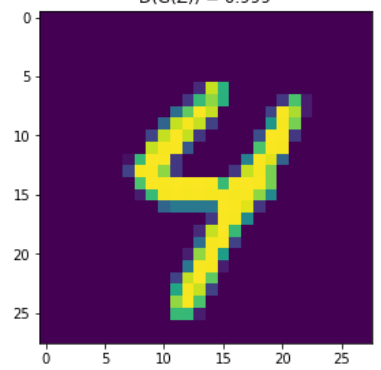

In [ ]:
# remove all
%reset -f

## Loading libraries

In [ ]:
# data handling
import copy
# numerical manipulation
import math
import numpy as np
# deep learning library pytorch
import torch
import torchvision.datasets as datasets
# visualization task
from IPython.display import clear_output
import matplotlib.pyplot as plt

## Possible Requirements:

In [ ]:
print('torch: ' + torch.__version__)
import torchvision
print('torchvision: ' + torchvision.__version__)
print('numpy: ' + np.__version__)
import matplotlib
print('matplotlib: ' + matplotlib.__version__)
import IPython
print('IPython: ' + IPython.__version__)

torch: 1.10.0+cu111
torchvision: 0.11.1+cu111
numpy: 1.19.5
matplotlib: 3.2.2
IPython: 5.5.0


## Preparing the Transfer Learning Data Set

All samples with digits from 0 to 8 are used in a source task data set. The source task is defined by a multi-class classification problem in order to classify those digits. The target task is defined to classify the digits 7 and 9. Therefore the target dataset only includes those digits. While the source training data set includes more than 54.000 samples, the target training data set is limited to 32 (randomly picked) samples. The challange is to train an optimal classifier for this limited set of training samples.

In [ ]:
def load_prepare_mnsit(set_name):
  """
  This function loads the data. If the data is not yet available on the computer,
  an internet connection is required here. In this case, the MNIST data will be
  downloaded once. Otherwise, the data is loaded from a local directory './data'.
  """
  if set_name=='train':
    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
    raw_int_data = dataset.data.numpy()
    labels = dataset.targets.numpy()

  elif set_name=='test':
    dataset = datasets.MNIST(root='./data', train=False, download=True, transform=None)
    raw_int_data = dataset.data.numpy()
    labels = dataset.targets.numpy()
  y = np.float32(labels.reshape(-1,1) == np.arange(10))
  X = (np.float32(raw_int_data[:,:])/255).reshape(-1,28*28)*2 - 1
  return X, y, labels

def filter_labels(X,y,labels,fltr_labels):
  y = y[:,fltr_labels]
  bool_idx = np.array([l in fltr_labels for l in labels])
  idx = np.where(bool_idx)[0]
  return X[idx],y[idx],labels[idx]

def create_tl_data_set(file_name,src=[0,1,2,3,4,5,6,7,8],trgt=[7,9],trgt_size=None):
  """
  src: source labels
  trgt: target labels
  """
  X_all, y_all, labels_all = load_prepare_mnsit(file_name)
  data = dict()
  # source data
  X_src,y_src,labels_src = filter_labels(X_all, y_all, labels_all, src)
  data['src'] = dict(X=X_src,y=y_src,labels=labels_src)
  # target data
  X_trgt,y_trgt,labels_trgt = filter_labels(X_all, y_all, labels_all, trgt)
  if trgt_size:
    subset_idx = np.random.randint(0,X_trgt.shape[0],trgt_size)
    data['trgt'] = dict(X=X_trgt[subset_idx],y=y_trgt[subset_idx],labels=labels_trgt[subset_idx])
  else:
    data['trgt'] = dict(X=X_trgt,y=y_trgt,labels=labels_trgt)
  return data

# dictionary with all training data (including source and target task)
data_train = create_tl_data_set('train', trgt_size=32)
# dictionary with all test data (including source and target task)
data_test = create_tl_data_set('test')

In [ ]:
print('~~~ Training set ~~~\n')
print(f"Number of source samples: {data_train['src']['X'].shape[0]}")
print(f"Source input shape: {data_train['src']['X'].shape[1]}")
print(f"Number of source classes: {data_train['src']['y'].shape[1]}")
print('')
print(f"Number of target samples: {data_train['trgt']['X'].shape[0]}")
print(f"Target input shape: {data_train['trgt']['X'].shape}")
print(f"Number of target classes: {data_train['trgt']['y'].shape[1]}")

print('\n~~~ Test set ~~~\n')
print(f"Number of source samples: {data_test['src']['X'].shape[0]}")
print(f"Source input shape: {data_test['src']['X'].shape[1]}")
print(f"Number of source classes: {data_test['src']['y'].shape[1]}")
print('')
print(f"Number of target samples: {data_test['trgt']['X'].shape[0]}")
print(f"Target input shape: {data_test['trgt']['X'].shape}")
print(f"Number of target classes: {data_test['trgt']['y'].shape[1]}")

~~~ Training set ~~~

Number of source samples: 54051
Source input shape: 784
Number of source classes: 9

Number of target samples: 32
Target input shape: (32, 784)
Number of target classes: 2

~~~ Test set ~~~

Number of source samples: 8991
Source input shape: 784
Number of source classes: 9

Number of target samples: 2037
Target input shape: (2037, 784)
Number of target classes: 2


## Model Classes

In [ ]:
class MlpClassifier(torch.nn.Module):
  def __init__(self, num_in, num_out, num_hidden=100,num_features=20):
    super().__init__()

    self.feature_layers = torch.nn.Sequential(
        torch.nn.Linear(num_in,num_hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Dropout(0.1),
        torch.nn.Linear(num_hidden,num_hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Dropout(0.1),
        torch.nn.Linear(num_hidden,num_hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(num_hidden,num_features),
        torch.nn.LeakyReLU(),
    )

    self.out_layers = torch.nn.Sequential(
        torch.nn.Linear(num_features,num_out),
    )
  def forward(self, X):
    return self.out_layers(self.feature(X))

  def feature(self, X):
    return self.feature_layers(X)

class LogisticRegression(torch.nn.Module):
  def __init__(self, num_in, num_out):
    super().__init__()
    self.lin = torch.nn.Linear(num_in,num_out)
  def forward(self, X):
    return self.lin(X)

class SmallMlp(torch.nn.Module):
  def __init__(self, num_in, num_out, num_hidden=100):
    super().__init__()
    self.layers = torch.nn.Sequential(
        torch.nn.Linear(num_in,num_hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(num_hidden,num_hidden),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(num_hidden,num_out)
    )
  def forward(self, X):
    return self.layers(X)

## Training / Helper Functions

In [ ]:
def accuracy(ysim,y):
  with torch.no_grad():
    pred = torch.argmax(ysim,axis=1)
    return torch.mean(y[torch.arange(y.shape[0]),pred]).item()

def train_test_split(X,y,train_test_ratio=0.25):
  test_bool = torch.rand(X.shape[0])<train_test_ratio
  X_train = X[~test_bool]
  y_train = y[~test_bool]
  X_test = X[test_bool]
  y_test = y[test_bool]
  return X_train,y_train,X_test,y_test

def train(X,y,mdl,criterion,optimizer,num_iterations,batch_size):
  train_loss_history = []
  valid_loss_history = []
  mdl.train()
  train_loss_sum = 0.0
  count = 0
  X_train,y_train,X_valid,y_valid = train_test_split(X,y)
  valid_loss_best = float('inf')
  for i in range(num_iterations):
    batch_idx = torch.randint(X_train.shape[0],size=(batch_size,))
    ysim = mdl.forward(X_train[batch_idx])
    loss = criterion(ysim,y_train[batch_idx])
    train_loss_sum += loss.item()
    count += 1
    mdl.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % math.floor(num_iterations/20) == 0:
      with torch.no_grad():
        ysim = mdl.forward(X_valid)
        valid_loss = criterion(ysim,y_valid)
      train_loss_history.append(train_loss_sum/count)
      valid_loss_history.append(valid_loss)
      if valid_loss<valid_loss_best:
        valid_loss_best = valid_loss
        mdl_out = copy.deepcopy(mdl)
      train_loss_sum = 0.0
      count = 0
      clear_output()
      plt.semilogy(train_loss_history,label='train')
      plt.semilogy(valid_loss_history,label='valid')
      plt.legend()
      plt.ylabel('avg. loss (train)')
      plt.xlabel('iteration / 20')
      plt.title(f'best validation loss: {valid_loss_best:.3f}')
      plt.show()
  return mdl_out, dict(train_loss=train_loss_history,valid_loss=valid_loss_history)

## Training of the Source Model

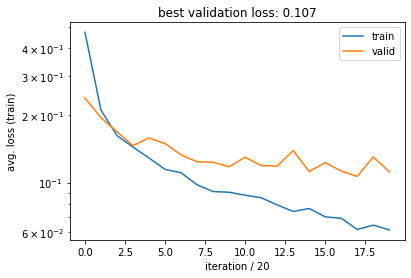

In [ ]:
X_src = torch.from_numpy(data_train['src']['X']);
y_src = torch.from_numpy(data_train['src']['y']);
mdl_src = MlpClassifier(X_src.shape[1],y_src.shape[1])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mdl_src.parameters())

num_iterations = 20000
batch_size = 32
mdl_src, loss_history = train(X_src,y_src,mdl_src,criterion,optimizer,num_iterations,batch_size)

In [ ]:
print('Source task, test data:')
X_src = torch.from_numpy(data_test['src']['X']);
y_src = torch.from_numpy(data_test['src']['y']);
with torch.no_grad():
  mdl_src.eval()
  ysim = mdl_src.forward(X_src)
  print(f'\tAccuracy: \t{accuracy(ysim,y_src)*100:.2f}%')
  print(f'\tCross Entropy: \t{criterion(ysim,y_src):.4f}')

Source task, test data:
	Accuracy: 	97.94%
	Cross Entropy: 	0.0753


## Training of the Target Model with Transfer Learning

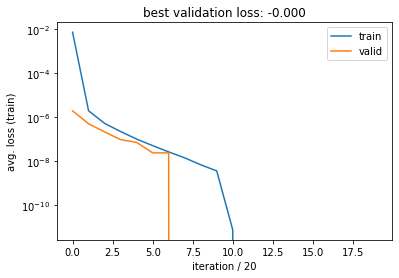

In [ ]:
X_trgt = torch.from_numpy(data_train['trgt']['X'])
y_trgt = torch.from_numpy(data_train['trgt']['y'])

feature_trgt = mdl_src.feature(X_trgt).detach()
print(feature_trgt.shape)

#mdl_trgt = LogisticRegression(feature_trgt.shape[1],y_trgt.shape[1])
mdl_trgt = SmallMlp(feature_trgt.shape[1],y_trgt.shape[1])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mdl_trgt.parameters())

num_iterations = 20000
batch_size = 32
mdl_trgt, loss_history_mdl_trgt = train(feature_trgt,y_trgt,mdl_trgt,criterion,optimizer,num_iterations,batch_size)

In [ ]:
print('Target task, test data, with transfer learning:')
X_trgt = torch.from_numpy(data_test['trgt']['X'])
y_trgt = torch.from_numpy(data_test['trgt']['y'])

feature_trgt = mdl_src.feature(X_trgt).detach()
with torch.no_grad():
  mdl_trgt.eval()
  ysim = mdl_trgt.forward(feature_trgt)
  print(f'\tAccuracy: \t{accuracy(ysim,y_trgt)*100:.2f}%')
  print(f'\tCross Entropy: \t{criterion(ysim,y_trgt):.4f}')

Target task, test data, with transfer learning:
	Accuracy: 	93.27%
	Cross Entropy: 	0.6448


## Training of the Target Model as Single Task Learning

Here, no transfer learning is applied.

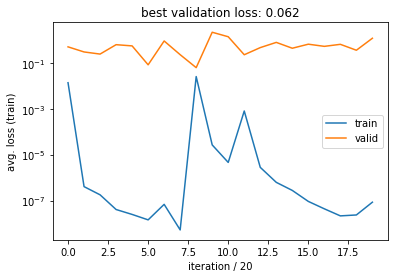

In [ ]:
X_trgt = torch.from_numpy(data_train['trgt']['X'])
y_trgt = torch.from_numpy(data_train['trgt']['y'])

mdl_trgt_no_transfer = MlpClassifier(X_trgt.shape[1],y_trgt.shape[1])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mdl_trgt_no_transfer.parameters())

num_iterations = 20000
batch_size = 32
mdl_trgt_no_transfer, loss_history_no_transfer = train(X_trgt,y_trgt,mdl_trgt_no_transfer,criterion,optimizer,num_iterations,batch_size)

In [ ]:
print('Target task, test data, no transfer learning:')
X_trgt = torch.from_numpy(data_test['trgt']['X']);
y_trgt = torch.from_numpy(data_test['trgt']['y']);

with torch.no_grad():
  mdl_trgt_no_transfer.eval()
  ysim = mdl_trgt_no_transfer.forward(X_trgt)

  print(f'\tAccuracy: \t{accuracy(ysim,y_trgt)*100:.2f}%')
  print(f'\tCross Entropy: \t{criterion(ysim,y_trgt):.4f}')

Target task, test data, no transfer learning:
	Accuracy: 	82.13%
	Cross Entropy: 	1.2325
